In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten
from keras.models import load_model
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from IPython.display import display, HTML
import json
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


/kaggle/input/sp-500-stocks/sp500_stocks.csv
/kaggle/input/sp-500-stocks/sp500_companies.csv
/kaggle/input/sp-500-stocks/sp500_index.csv
/kaggle/input/cnn-spx-pretrained-model/cnnspx_hist.json
/kaggle/input/cnn-spx-pretrained-model/cnnspx.h5


try to analyse/predict S&P 500 prices using Convolutional NN: Conv1D layer + NN

The last 1250 records are used about 5 years worth.
The closing prices for a 14 days lookback window are used to train the neural net. split 80% train (4 years), 20% test (1 year)


In [ ]:
data = pd.read_csv('/kaggle/input/sp-500-stocks/sp500_index.csv',index_col='Date')
cl = pd.Series(data=data['S&P500'][-1250:])
#patch the last entry which is not yet available when generating this run
if cl.index[-1] == '2023-12-19':
    lc = pd.Series([4698.35],index=['2023-12-20'])
    cl = pd.concat([cl, lc])
    #lc = pd.Series([3983.17],index=['2023-01-12'])
    #cl = cl.append(lc)
cl.tail()

2023-12-14    4719.55
2023-12-15    4719.19
2023-12-18    4740.56
2023-12-19    4768.37
2023-12-20    4698.35
dtype: float64

In [ ]:
cv = cl.values

scl = MinMaxScaler()
cv = cv.reshape(cv.shape[0],1)
cv = scl.fit_transform(cv)
display(cv[0:10])

array([[0.08224964],
       [0.11509245],
       [0.12202832],
       [0.13168774],
       [0.13581019],
       [0.14037419],
       [0.1402257 ],
       [0.13489192],
       [0.14571187],
       [0.14797824]])

In [ ]:
def processData(data,lb,gap):
    X,Y = [],[]
    for i in range(len(data)-lb-gap):
        X.append(data[i:(i+lb),0])
        Y.append(data[(i+lb+gap),0])
    return np.array(X),np.array(Y)
X,y = processData(cv,14,1)
X_train,X_test = X[:int(X.shape[0]*0.80)],X[int(X.shape[0]*0.80):]
y_train,y_test = y[:int(y.shape[0]*0.80)],y[int(y.shape[0]*0.80):]
print(X_train.shape[0])
print(X_test.shape[0])
print(y_train.shape[0])
print(y_test.shape[0])

988
248
988
248


In [ ]:
#Build the model
model = Sequential()
model.add(Conv1D(5,3, strides=1, activation='relu',input_shape=(14,1)))
model.add(Flatten())
#model.add(Dense(10, activation='relu',input_shape=(14,)))
model.add(Dense(40, activation='sigmoid'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',loss='mse')
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 12, 5)             20        
                                                                 
 flatten (Flatten)           (None, 60)                0         
                                                                 
 dense (Dense)               (None, 40)                2440      
                                                                 
 dense_1 (Dense)             (None, 1)                 41        
                                                                 
Total params: 2501 (9.77 KB)
Trainable params: 2501 (9.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [ ]:
#Reshape data for (Sample,Timestep,Features)
X_train = X_train.reshape((X_train.shape[0],X_train.shape[1],1))
X_test = X_test.reshape((X_test.shape[0],X_test.shape[1],1))
print(X_train.shape)
print(X_train[0])
print(X_train[1])

(988, 14, 1)
[[0.08224964]
 [0.11509245]
 [0.12202832]
 [0.13168774]
 [0.13581019]
 [0.14037419]
 [0.1402257 ]
 [0.13489192]
 [0.14571187]
 [0.14797824]
 [0.1557386 ]
 [0.16931728]
 [0.1545429 ]
 [0.15680927]]
[[0.11509245]
 [0.12202832]
 [0.13168774]
 [0.13581019]
 [0.14037419]
 [0.1402257 ]
 [0.13489192]
 [0.14571187]
 [0.14797824]
 [0.1557386 ]
 [0.16931728]
 [0.1545429 ]
 [0.15680927]
 [0.1582277 ]]


In [ ]:
loadflag = True
model_file = "cnnspx.h5"
hist_file = "cnnspx_hist.json"
hist = []
#Fit model with history to check for overfitting
if not loadflag:
    history = model.fit(X_train,y_train,epochs=200,validation_data=(X_test,y_test),shuffle=False,verbose=2)
    hist = history.history
    model.save(model_file)
    with open(hist_file, "w") as f:
        json.dump(hist,f)
else:
    input_dir = '../input/cnn-spx-pretrained-model/'
    model = load_model(input_dir + model_file)
    with open(input_dir + hist_file) as f:
        hist = json.load(f)

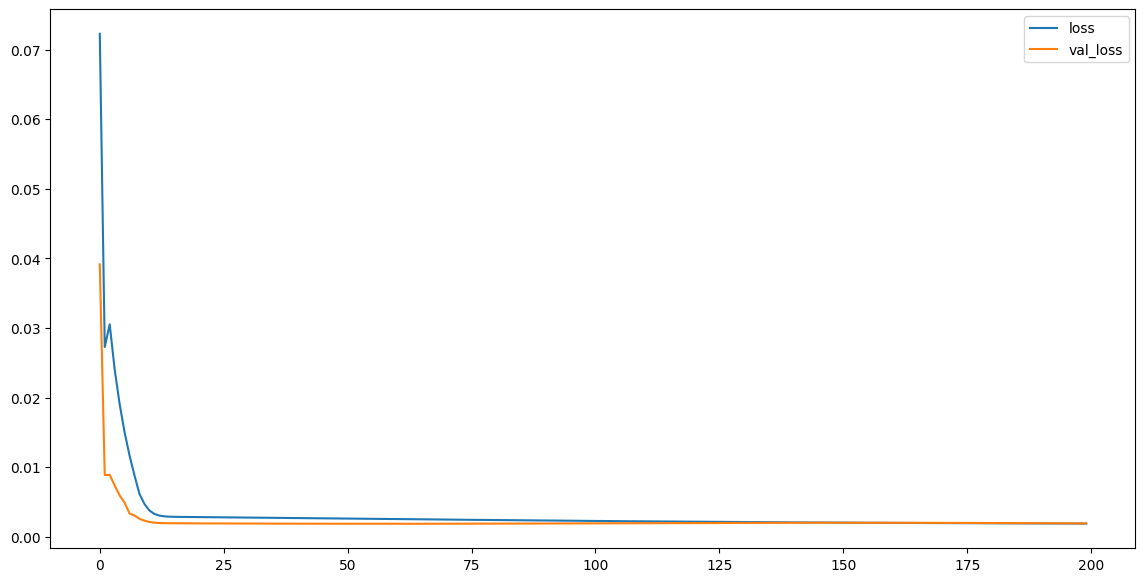

In [ ]:
plt.figure(figsize=(14,7))
plt.plot(hist['loss'],label='loss')
plt.plot(hist['val_loss'],label='val_loss')
plt.legend()
plt.show()

In [ ]:
#print weights of 1st layer
for layer in model.layers:
    print(layer.get_config())
    print(layer.get_weights())
    break

{'name': 'conv1d', 'trainable': True, 'dtype': 'float32', 'batch_input_shape': (None, 14, 1), 'filters': 5, 'kernel_size': (3,), 'strides': (1,), 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': (1,), 'groups': 1, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}
[array([[[ 0.5924961 ,  0.40553162,  0.6129217 , -0.1959265 ,
          0.11181611]],

       [[ 0.43256932,  0.20680308, -0.10669319,  0.22338484,
         -0.00999002]],

       [[-0.10934886, -0.00587296,  0.57138866, -0.21691708,
          0.5983536 ]]], dtype=float32), array([-0.11685053, -0.10793299, -0.10197737,  0.18396626, -0

In [ ]:
X_test[0]

array([[0.68828834],
       [0.66578877],
       [0.66292065],
       [0.67448303],
       [0.66310039],
       [0.68505291],
       [0.69641992],
       [0.68691289],
       [0.6480056 ],
       [0.63105081],
       [0.61749168],
       [0.61903906],
       [0.64124166],
       [0.61933994]])

In [ ]:
Xt = model.predict(X_test)
yactual = pd.Series(scl.inverse_transform(y_test.reshape(-1,1)).reshape(-1))
ypred = pd.Series((scl.inverse_transform(Xt)).reshape(-1))

8/8 [==============================] - 5s 3ms/step


In [ ]:
yema = yactual.ewm(span=3).mean()
signal = pd.Series(index = yactual.index, data = np.zeros(yactual.size))
pdiff = ypred.diff(3)
adiff = yema.diff(3)
print(adiff[-5:])
print(pdiff[-5:])
for i in yactual.index:
    if (pdiff[i] > 0 and adiff[i] > 0) or (pdiff[i] < 0 and adiff[i] < 0):
        signal[i] = 4700.0
    else:
        signal[i] = 4600.0
del pdiff
del adiff

243    87.205280
244    81.347640
245    57.408820
246    53.114410
247    16.137205
dtype: float64
243    11.144531
244    21.134766
245    25.627930
246    30.127441
247    29.126953
dtype: float32


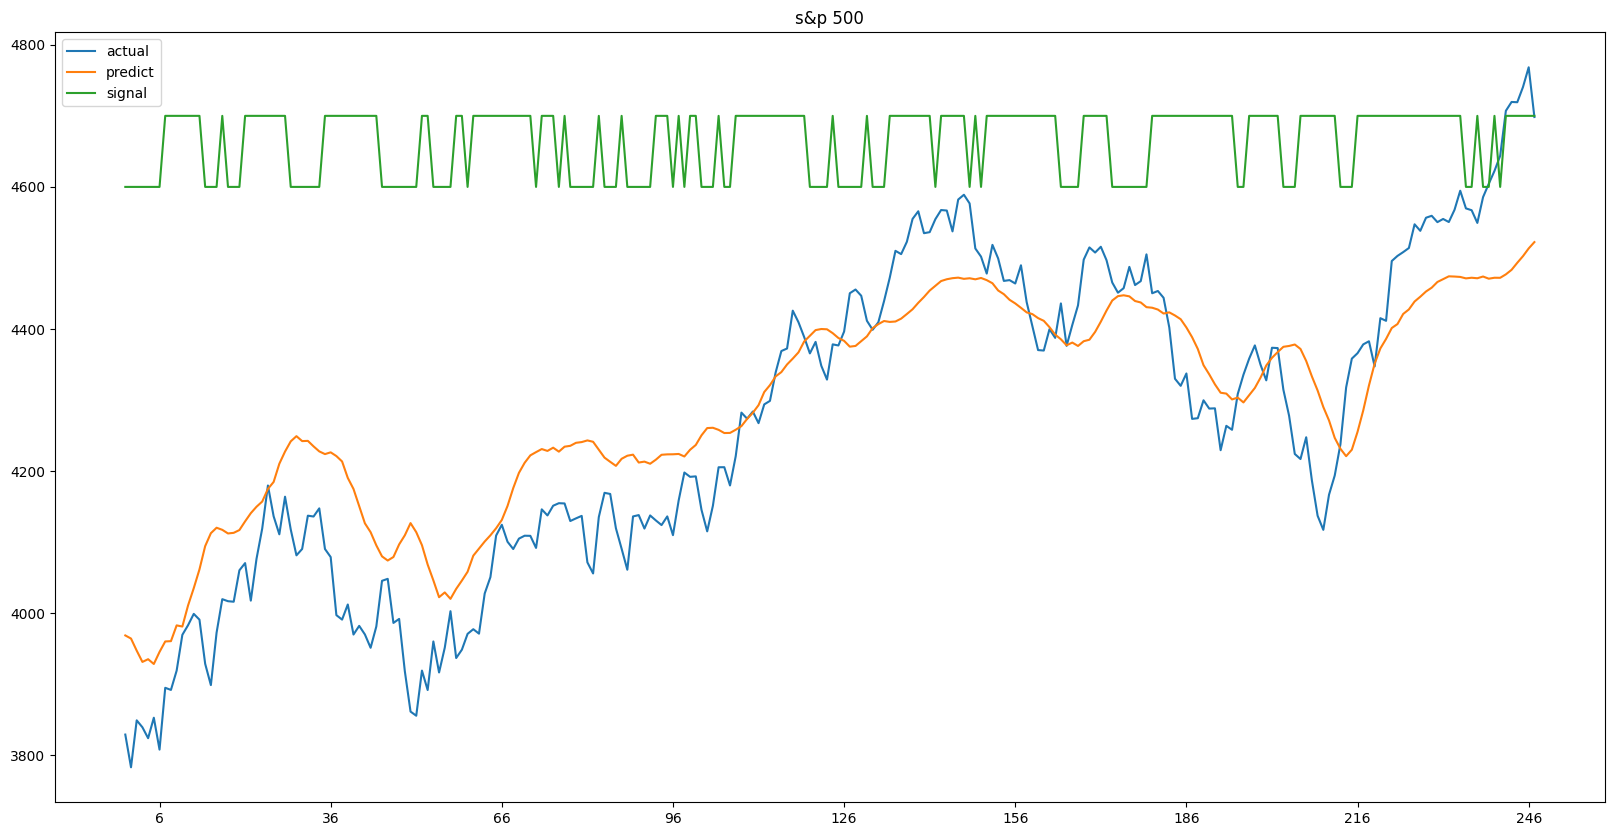

In [ ]:
plt.figure(figsize=(20,10))
ax = plt.axes()
ax.plot(yactual, label='actual')
ax.plot(ypred, label='predict')
#plt.plot(yema)
ax.plot(signal, label='signal')
ax.set_xticks(yactual.index[6::30])
#plt.annotate('late pred',(137,4200))
#plt.axvline(x=135.0, color='r', linestyle='-')
#plt.annotate('late pred',(233,4300))
#plt.axvline(x=333, color='r', linestyle='-')
plt.title('s&p 500')
plt.legend()
plt.show()

blurb: The predictions looks pretty much like some sort of (exponential) moving average. While it seemed to be 'trend following', the predictions tend to be late. The predictions tend to 'smooth out' actual fluctations which is quite a lot larger in actual prices.
between v30 - 31, the number of filters in the 1st layer is increased from 3 to 5, that apparently increased the accuracy significantly, losses reduced by a factor of 10, but that the number of parameters in the subsequent layers increased significantly as well

In [ ]:
#show the last 10 actual values
scl.inverse_transform(y_test.reshape(-1,1))[-10:]

array([[4585.59],
       [4604.37],
       [4622.44],
       [4643.7 ],
       [4707.09],
       [4719.55],
       [4719.19],
       [4740.56],
       [4768.37],
       [4698.35]])

In [ ]:
#show the last 10 predict values
scl.inverse_transform(Xt)[-10:]

array([[4473.8936],
       [4470.8496],
       [4472.1606],
       [4472.079 ],
       [4476.936 ],
       [4483.305 ],
       [4493.214 ],
       [4502.564 ],
       [4513.4326],
       [4522.341 ]], dtype=float32)